First we import all the necessary libraries that we will need.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm
import zipfile

In [35]:
with zipfile.ZipFile("titanic.zip","r")as zipref:
    zipref.extractall("titanic_dataset")

Upon extracting our zipfile we can see it contains three .csv files, which are - 
gender_submission.csv, test.csv, train.csv

We will be training our model on the train dataset, and then test it against the test dataset.

In [36]:
train_data = pd.read_csv("titanic_dataset/train.csv")
test_data = pd.read_csv("titanic_dataset/test.csv")

In [37]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## EDA

In [38]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


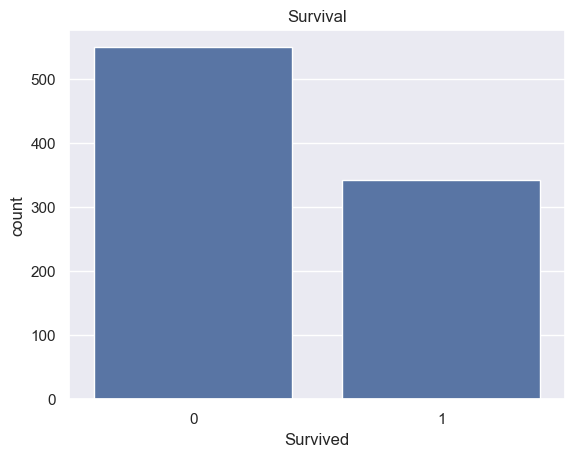

In [39]:
sns.countplot(x="Survived",data= train_data)
plt.title("Survival")
plt.show()

## Boxplots

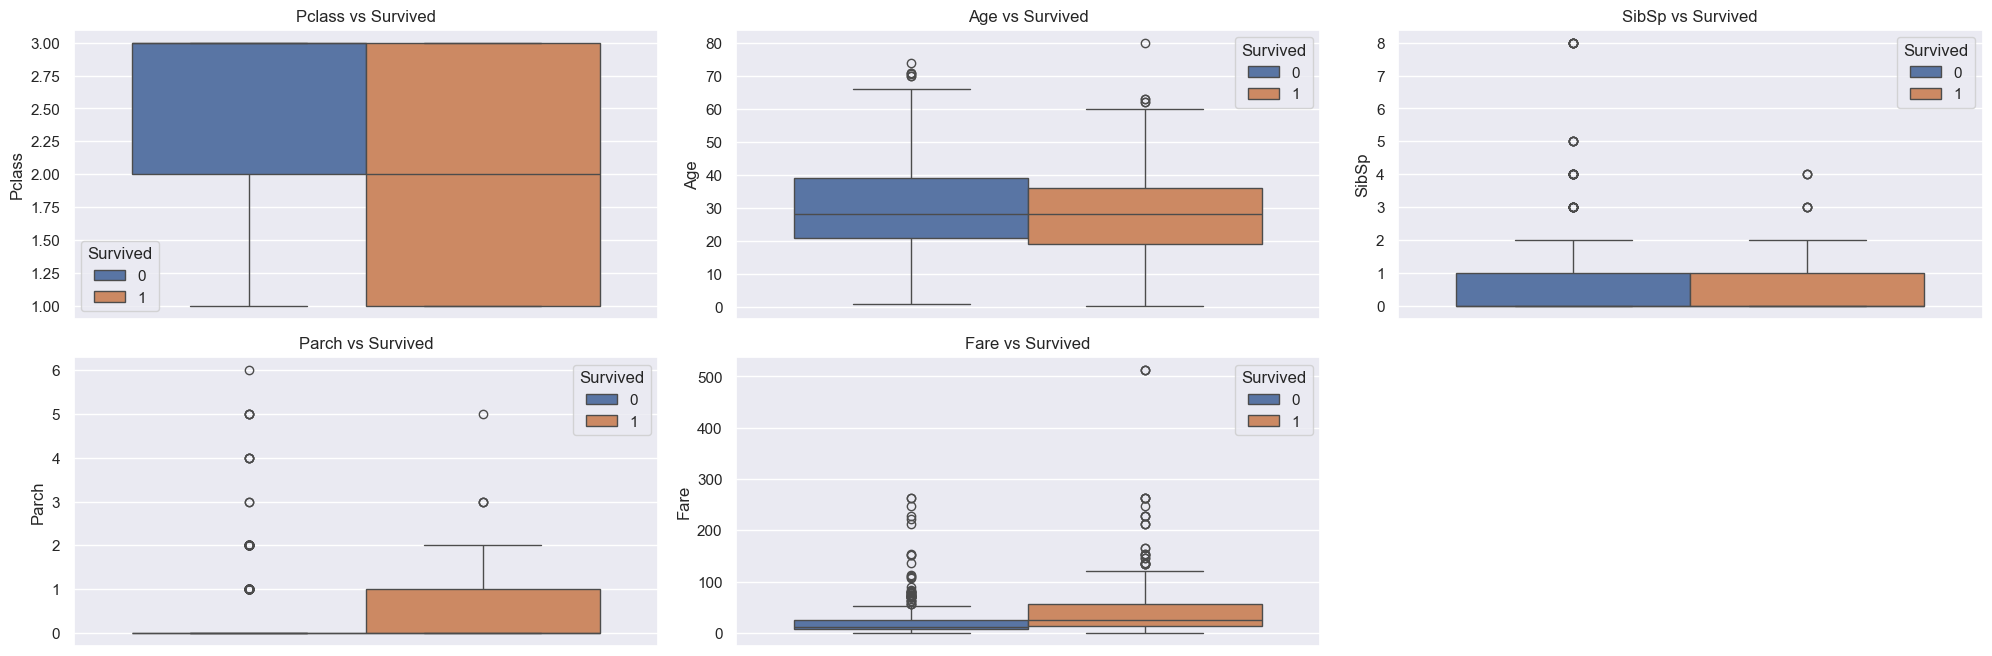

In [40]:
num_cols= []
num_cols= train_data.select_dtypes(include=['int64','float64']).columns
num_cols=num_cols.drop("Survived")
num_cols=num_cols.drop("PassengerId")
plt.figure(figsize=(20,10))
for i,col in enumerate(num_cols,start=1):
    plt.subplot(3,3,i)
    sns.boxplot(hue="Survived",y=col,data=train_data)
    plt.title(f"{col} vs Survived")

plt.tight_layout()
plt.show()

## Histograms

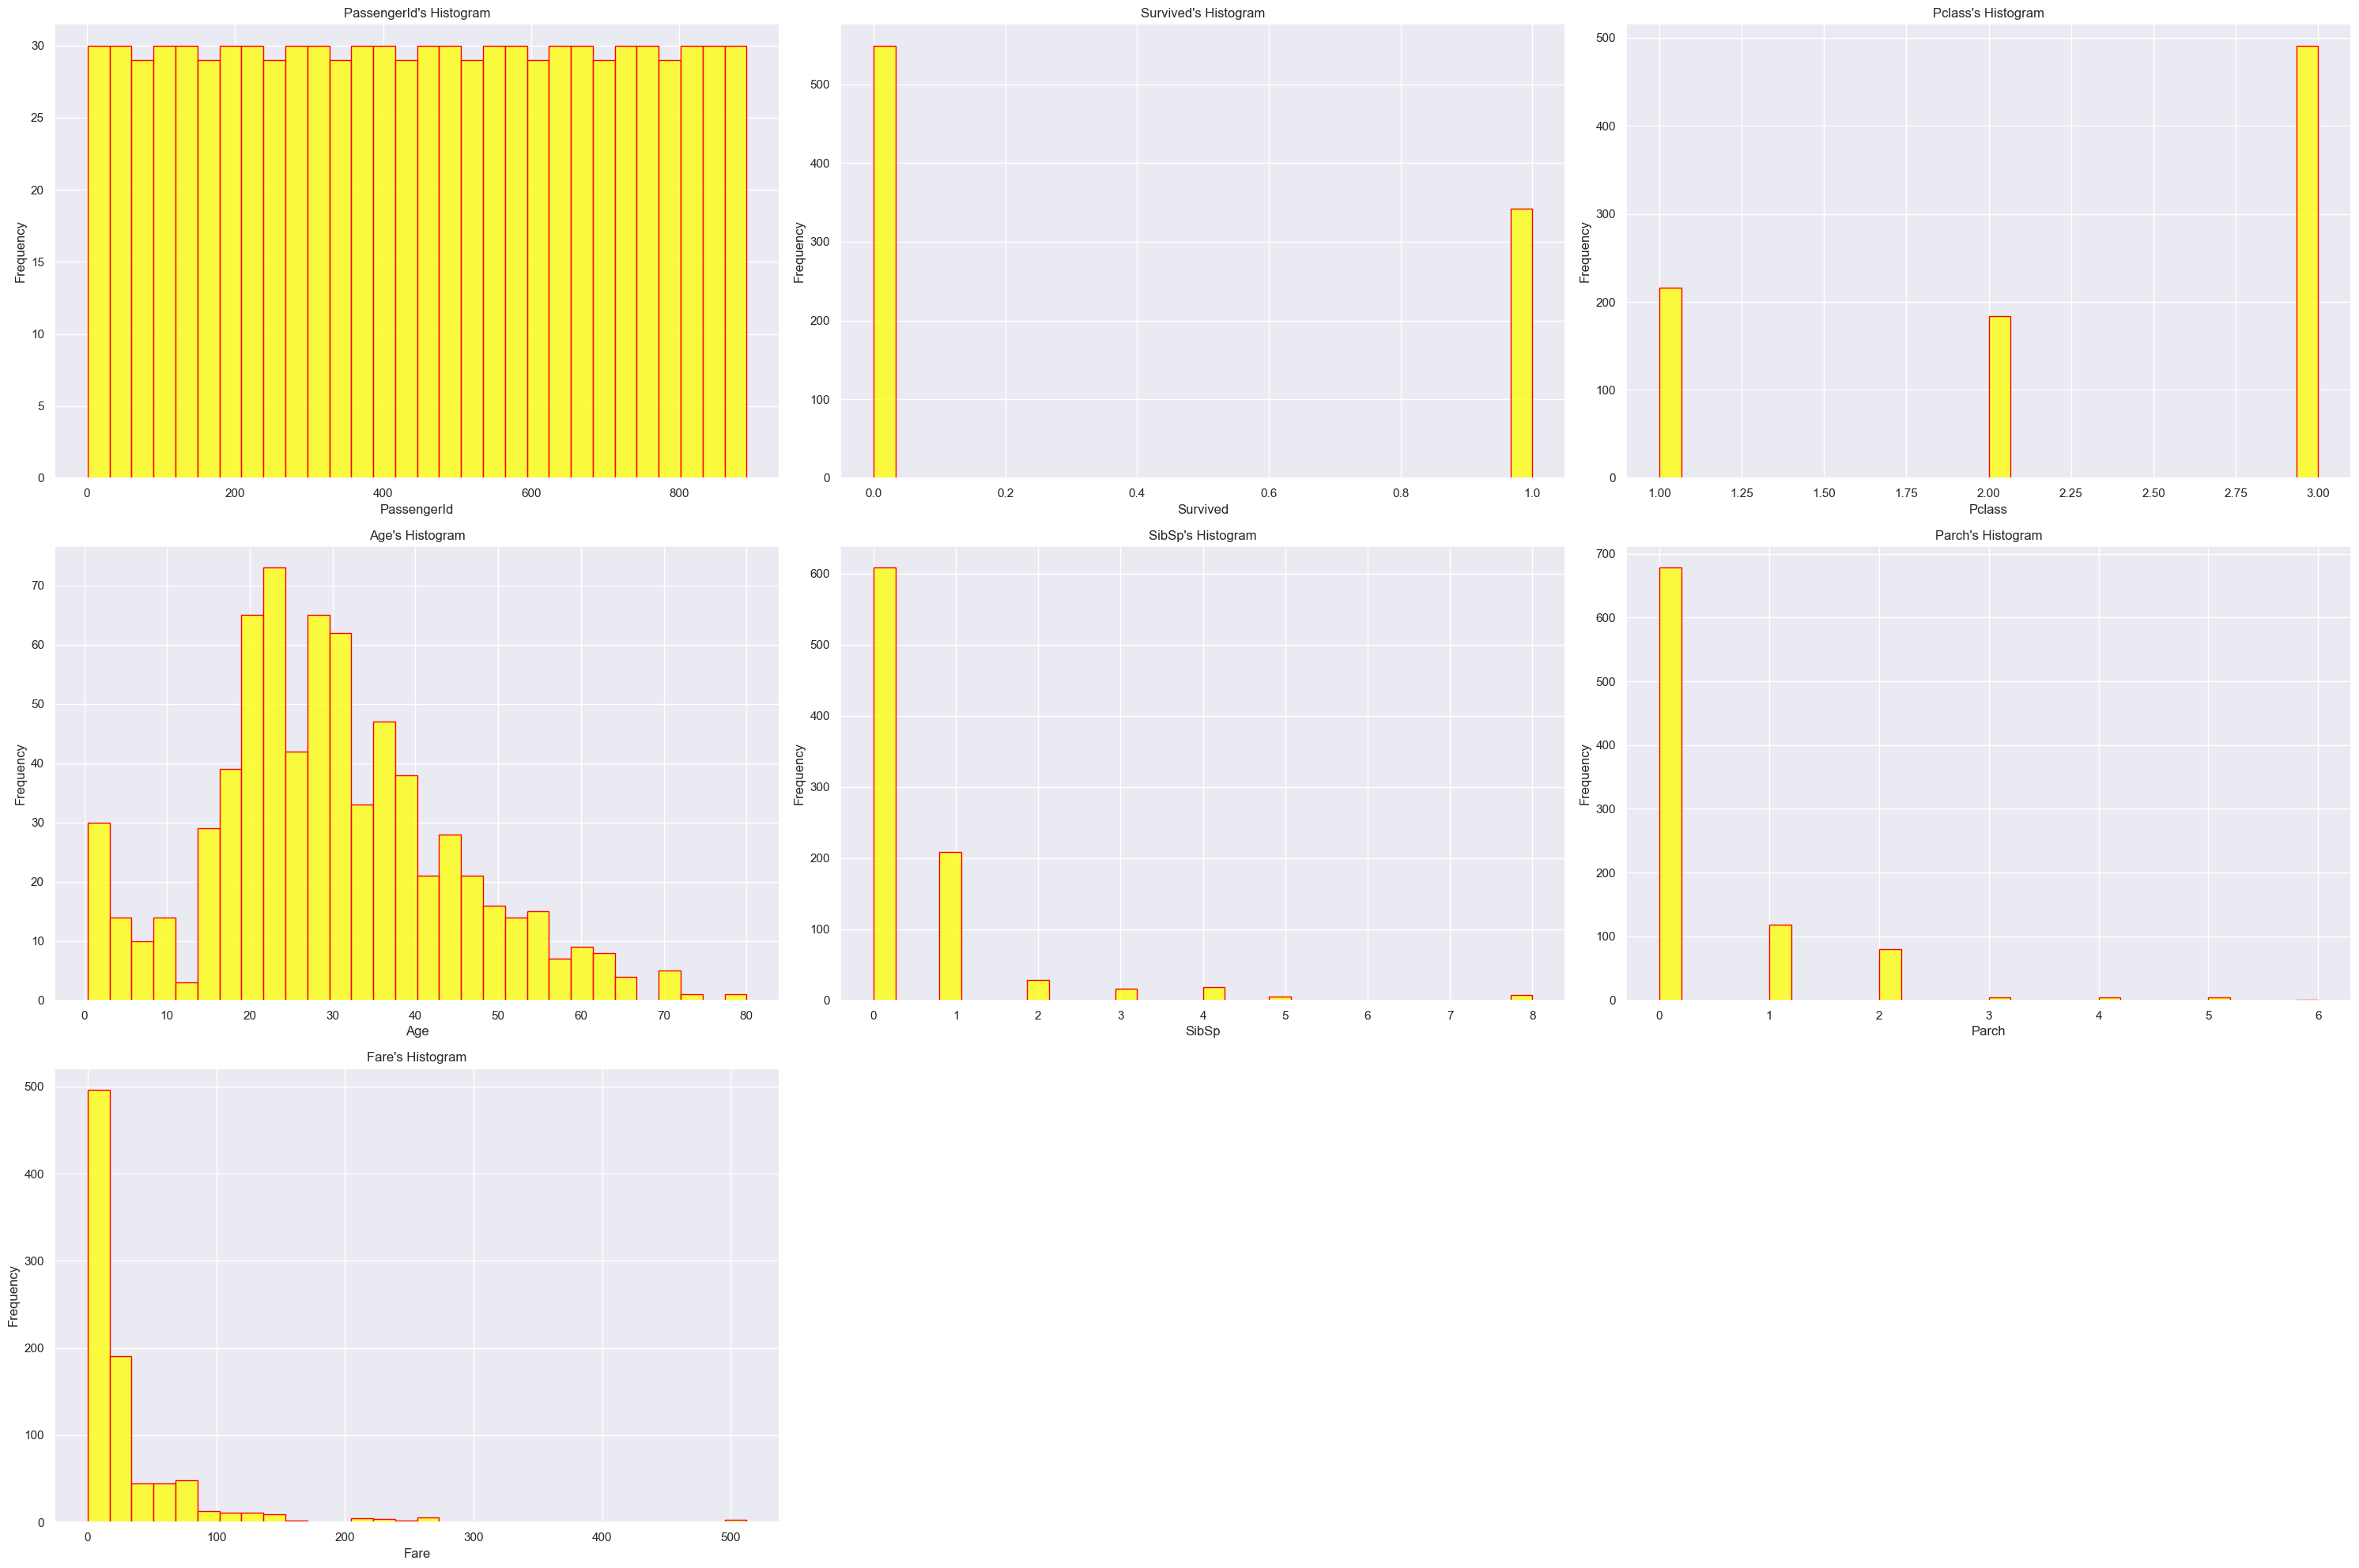

In [41]:
num_cols= []
num_cols= train_data.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(30,20))

for i,col in enumerate(num_cols,start=1):
    plt.subplot(3,3,i)
    sns.histplot(x=train_data[col].dropna(),data=train_data,bins=30,color="yellow",edgecolor="red")
    plt.ylabel("Frequency")
    plt.title(f"{col}'s Histogram")

plt.tight_layout()
plt.show()

## Preprocessing

In [42]:
print(f"Null values:\n",train_data.isnull().sum())

print(f"Duplicated data: ",train_data.duplicated().sum())

print(f"Categorical Columns:\n",[col for col in train_data.columns if train_data[col].dtype=="object"])

Null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Duplicated data:  0
Categorical Columns:
 ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


From the above observation, we can find that 'Age' and 'Cabin' column contain a lot of missing values. For the 'Embarked' column we can either drop them or fill them.

Transforming the categorical data in our 'Sex' column to numerical data

In [43]:
train_data['Sex'] = train_data['Sex'].astype(str).map({'male': 1, 'female': 0})
train_data['Sex']

test_data['Sex'] = test_data['Sex'].astype(str).map({'male': 1, 'female': 0})
test_data['Sex']

0      1
1      0
2      1
3      1
4      0
      ..
413    1
414    0
415    1
416    1
417    1
Name: Sex, Length: 418, dtype: int64

Handling the missing values in our 'Embarked' column and transforming the categorical data.

In [44]:
print(train_data['Embarked'].mode())
train_data['Embarked'].dtype

0    S
Name: Embarked, dtype: object


dtype('O')

In [45]:
train_data['Embarked']= train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
embarked_dummies = pd.get_dummies(train_data['Embarked'],prefix='Embarked',drop_first=True).astype(int)
train_data = pd.concat([train_data,embarked_dummies], axis=1)

test_data['Embarked']= test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])
embarked_dummies = pd.get_dummies(test_data['Embarked'],prefix='Embarked',drop_first=True).astype(int)
test_data = pd.concat([test_data,embarked_dummies], axis=1)

In [46]:
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].median())
test_data["Age"] = test_data["Age"].fillna(test_data["Age"].median()) 

In [47]:
train_data["log_Fare"] = np.log1p(train_data["Fare"])
test_data["log_Fare"] = np.log1p(test_data["Fare"])

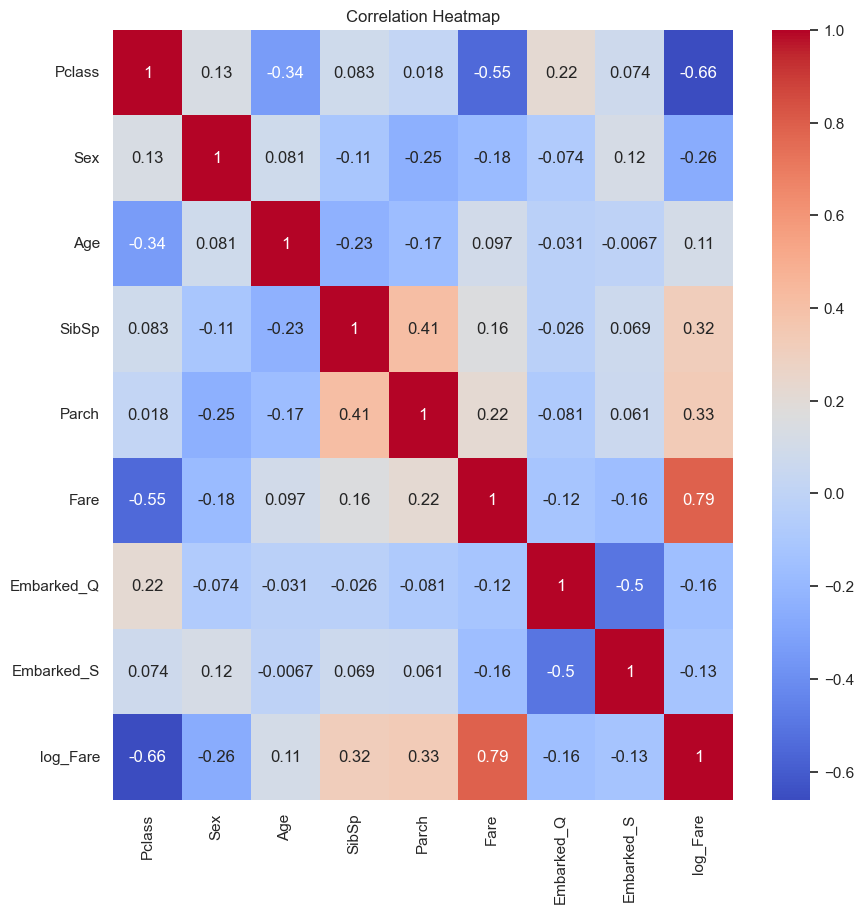

In [48]:
num_data = train_data.drop(columns=["PassengerId","Survived","Name","Ticket","Cabin","Embarked"],axis=1)

corr_matrix = num_data.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [49]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S,log_Fare
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0,0,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,1,3.990834
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,1,2.202765


In [50]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S,log_Fare
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,Q,1,0,2.178064
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,S,0,1,2.079442
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,Q,1,0,2.369075
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,S,0,1,2.268252
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,S,0,1,2.586824


## Variables

Dropping PassengerId, Name, Ticket, Cabin, Embarked column.
These columns are either not significant for our model or contain a lot of NaN values.

In [51]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Embarked_Q',
       'Embarked_S', 'log_Fare'],
      dtype='object')

In [52]:
y = train_data["Survived"]
x_with = train_data.drop(columns=["Survived", "PassengerId", "Name","Ticket","Cabin","Embarked"],axis=1)

#dropping Parch and Fare
x_without = train_data.drop(columns=["Parch","Fare","Survived","PassengerId","Name","Ticket","Cabin","Embarked"],axis=1)

test_passengerId = test_data["PassengerId"]
test_data = test_data.drop(columns=["Parch","Fare","PassengerId","Name","Ticket","Cabin","Embarked"],axis=1)

In [53]:
x_with.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,log_Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.647587,29.361582,0.523008,0.381594,32.204208,0.086420,0.725028,2.962246
std,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.281141,0.446751,0.969048
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,2.187218
50%,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,2.737881
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,1.000000,3.465736
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,6.240917


In [54]:
x_without.describe()

,Pclass,Sex,Age,SibSp,Embarked_Q,Embarked_S,log_Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.647587,29.361582,0.523008,0.086420,0.725028,2.962246
std,0.836071,0.477990,13.019697,1.102743,0.281141,0.446751,0.969048
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,0.000000,2.187218
50%,3.000000,1.000000,28.000000,0.000000,0.000000,1.000000,2.737881
75%,3.000000,1.000000,35.000000,1.000000,0.000000,1.000000,3.465736
max,3.000000,1.000000,80.000000,8.000000,1.000000,1.000000,6.240917


In [55]:
x1 = sm.add_constant(x_with)
result = sm.Logit(y, x1).fit()
result.summary()
print(f"AIC before reducting our dataset {result.aic}")

Optimization terminated successfully.
         Current function value: 0.437708
         Iterations 6
AIC before reducting our dataset 799.996389216773


In [56]:
x2 = sm.add_constant(x_without)
result = sm.Logit(y, x2).fit()
result.summary()
print(f"AIC after reducting our dataset {result.aic}")

Optimization terminated successfully.
         Current function value: 0.439149
         Iterations 6
AIC after reducting our dataset 798.5628536604348


Though the difference between the AIC's before and after isn't much, dropping Parch and Fare columns from our feature tends to reduce our AIC for the model.

Scaling down our Age and Fare columns

In [57]:
X_train, X_test, y_train, y_test = train_test_split(x_without, y, test_size=0.2, random_state=7)

In [58]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [60]:
preds =  log_model.predict(X_test)

In [61]:
print("On the training dataset, following are the results:\n")
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print("Confusion Matrix:\n",confusion_matrix(y_test, preds))
print("Classification Report:\n",classification_report(y_test, preds))

On the training dataset, following are the results:

Accuracy: 0.7541899441340782
Confusion Matrix:
 [[91 19]
 [25 44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.81       110
           1       0.70      0.64      0.67        69

    accuracy                           0.75       179
   macro avg       0.74      0.73      0.74       179
weighted avg       0.75      0.75      0.75       179



In [66]:
test_data["log_Fare"]=test_data["log_Fare"].fillna(test_data["log_Fare"].median())
test_data= scaler.transform(test_data)

In [67]:
preds_on_test = log_model.predict(test_data)

In [69]:
submission = pd.DataFrame({"PassengerId": test_passengerId,"Survived": preds_on_test})
submission.to_csv("submission.csv", index=False)